In [453]:
import pandas as pd
import numpy as np
import random
from IPython.display import Image
import collections
from kmeans import *
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
impo

%run kmeans

## 1. What is Kmeans

K-means is an unsupervised machine learning algorithm that is designed to group similar data points together based on their similarity. Depends on how many groups (or also knowns as clusters) we are trying to define, we want to group our data points into their corresponding clusters as the main objective. "K" here is a generic term indicating there could be however many of clusters we prefer to create. 

There are two terms that need to be clarified here, one is "unsupervised" the other is "similarity". K-means is unsupervised model because the input data is not labelled. However, the algorithem will allocate each data point to a cluster. "Similarity" in this context specifically means the euclidean distance between a data point and center of a cluster.

## 2. How does it work / Algorithm

1. Randomly initiate K centroids (pre-determined cluster center) in the same vector space as the data
2. Calculate the distance between each data point and each centroids; find the nearest centroid to the data point and allocate this data point to this cluster
3. After all the data points are assigned to their nearest centroids, compute the mean of the current cluster and update the cluster centroid to the new mean we just calculated
4. Repeat step 2 allowing each data point to find their nearest centroid again
5. Repeat step 2 to 4 until one of the following conditions is met:
    - k centroids have been samples
    - run out the max number of iterations

## 2. Visualize Kmeans

### 1D demonstration - we use a 1 dimensional data set to understand the concept

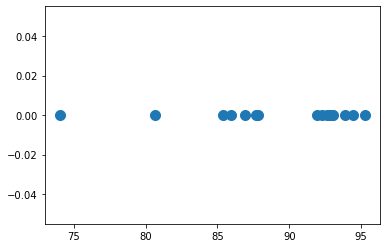

In [320]:
grades_1D = [92.65, 93.87, 74.06, 86.94, 92.26, 94.46, 92.94, 80.65, 92.86,
          85.94, 91.94, 95.23, 85.37, 87.85, 87.71, 93.03]
y = [0] * len(grades_1D)
plt.scatter(grades_1D, y, s=100)
plt.show()

we now fit this data set on the kmeans algorithm

In [321]:
centroids, labels = kmeans_1D(grades_1D, 4, tolerance=0.01)

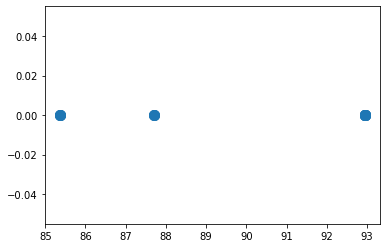

In [322]:
plt.scatter(labels, y, s=100)

Section Summary: 
- It is a little harder to see the overlap, but all the data is now grouped into 4 centroids indicated above

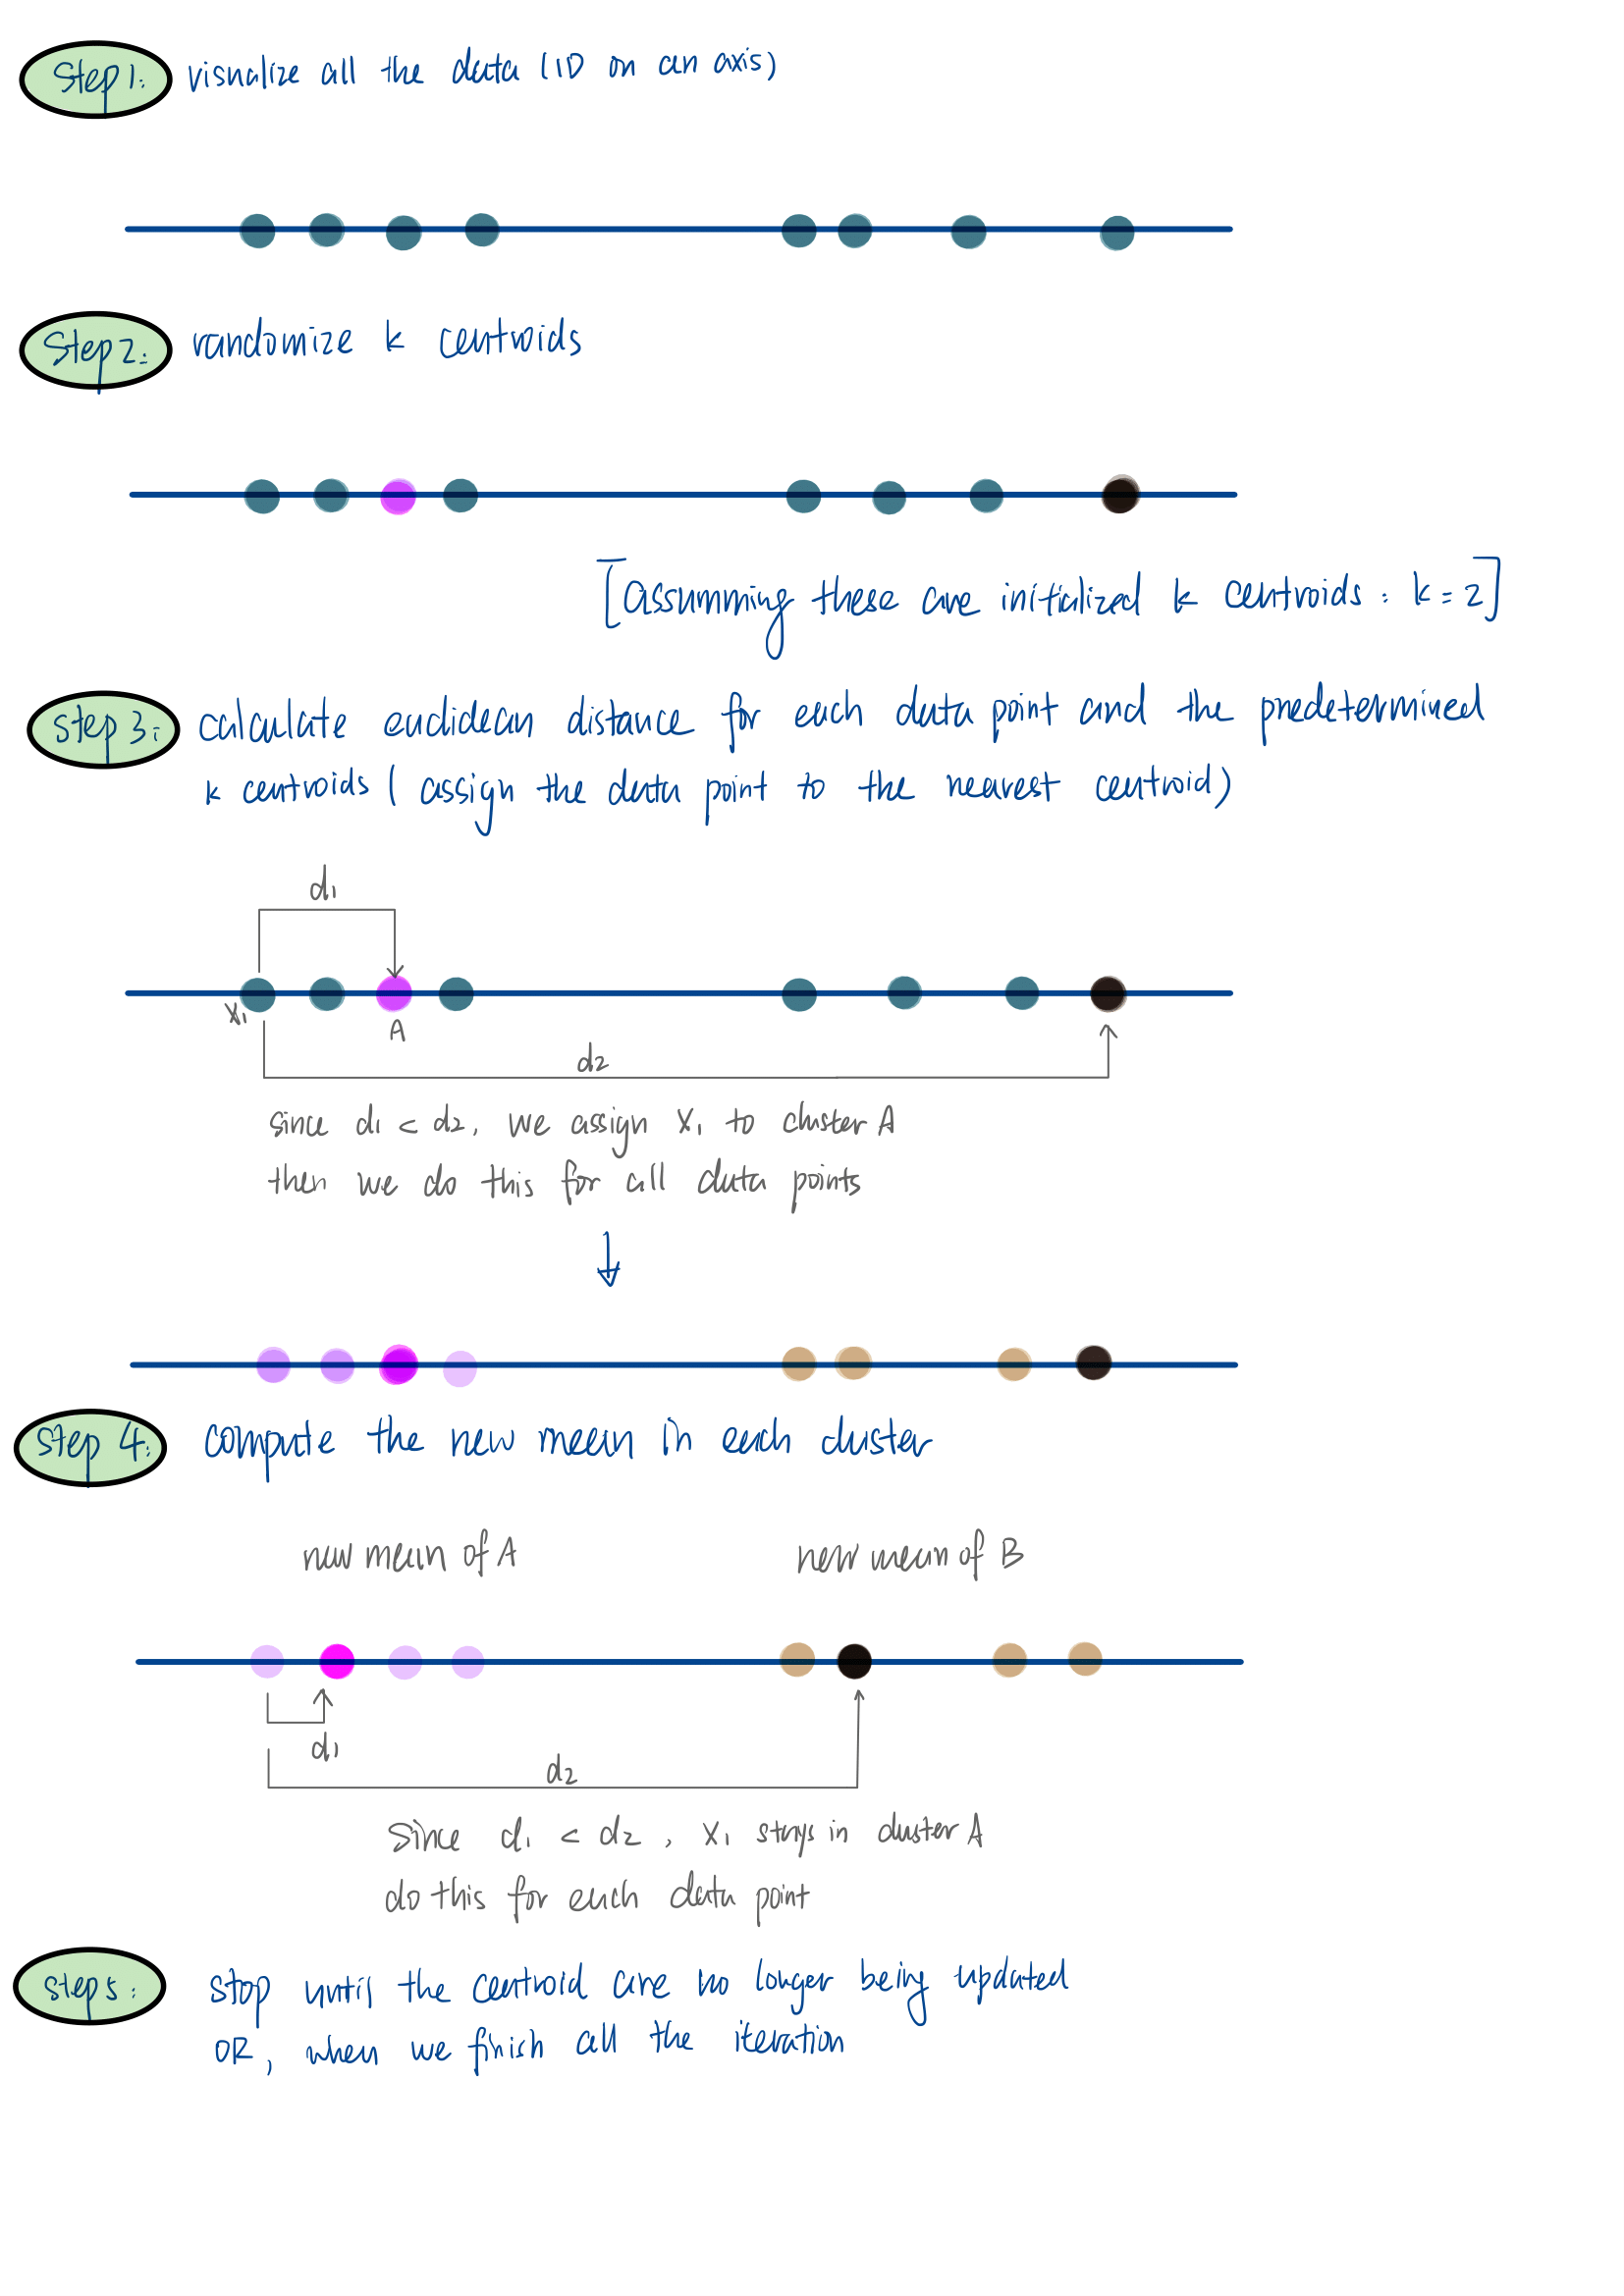

In [323]:
Image("1d_demo-1.png")

#### 2D dataset demonstration

we first randomize a dataset

In [364]:
X, _ = make_circles(n_samples=500, noise=0.1, factor=.2)
centroids, labels = kmeans(X, 2)
colors=np.array(['#4574B4','#A40227'])

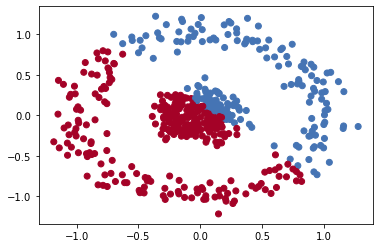

In [365]:
plt.scatter(X[:,0], X[:,1], c=colors[labels])
plt.show()

- we noticed that the clustering is not doing a great job as the middle circle should be clustered together, while the outter circle should be identified as a same group 
- **ISSUE 1** : not the best classification result

now we try to run the code coulple more times to see if the results are the same

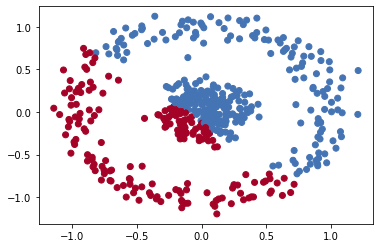

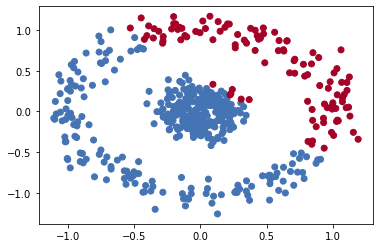

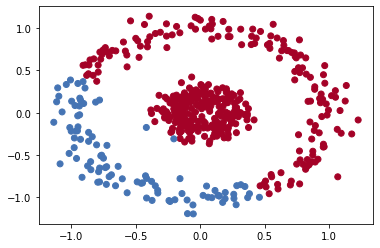

In [326]:
for i in range(3):
    X, _ = make_circles(n_samples=500, noise=0.1, factor=.2)
    centroids, labels = kmeans(X, 2, centroids=None)
    colors=np.array(['#4574B4','#A40227'])
    plt.scatter(X[:,0], X[:,1], c=colors[labels])
    plt.show()

We noticed that each cluster time is different. This is because K-means algorithm tends to look for the suboptimal location instead of global optimal. If the initializer is badly chosen, while the algorithm can still find the "best" point in relavent to the chosen initializer, it neglects the better solution in the dataset. 

- **ISSUE 2**: initializer K drastically impact the clustering result

## 3. Issues with the alogrithm / Improvement

based on the obversation above we noticed that:
1. k initializer heavily influence the clustering result. As such, the optimal case that's picked by the algorithm might not be the gloabl optimal
3. when the data has a more complex patter (like the "circle" above), the algorithm does not have accurate result

### Implement Kmean ++

The idea of Kmean++ is one of the improvements we can do in order to make the initialization result closer to the optimal (less random than just Kmeans). 

- Step 1: we first randomly select one initial point
- Step 2: for the rest points (k-1), we will compute the minimum distance between each data point and previously chosen centroid. Once we have a list of the minimum distance for each datapoint, we will find the maximum distance. 
    - the intuition behind this is the point having the maximum distance from the nearest centroid is most likely to be cohsen as the next centroid 
- Step 3: Repeat step 1 and 2 until all the K centroids are chosen

Now, let's add Kmean ++ into the algorithm and the result seems to be better:

#### without Kmean++

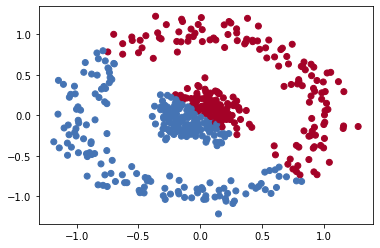

In [397]:
centroids, labels = kmeans(X, 2, centroids=None)
colors=np.array(['#4574B4','#A40227'])
plt.scatter(X[:,0], X[:,1], c=colors[labels])
plt.show()

#### with kmean++

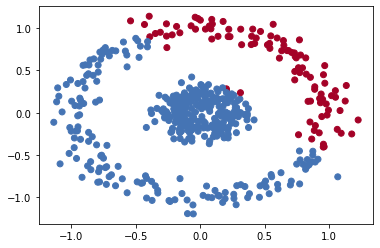

In [344]:
centroids, labels = kmeans(X, 2, centroids='kmeans++')
colors=np.array(['#4574B4','#A40227'])
plt.scatter(X[:,0], X[:,1], c=colors[labels])
plt.show()

- we can see that the kmean++ is able to better select the initializer, such that the inner circle dots are no longer categorized together with the outter circle
- however, this is still not ideal as it **did not successfully identify the outter circle as a group**

### Improving with kmeans++ and spectral clustering

#### The difference between Kmeans and Spectrual clustering is show as following:

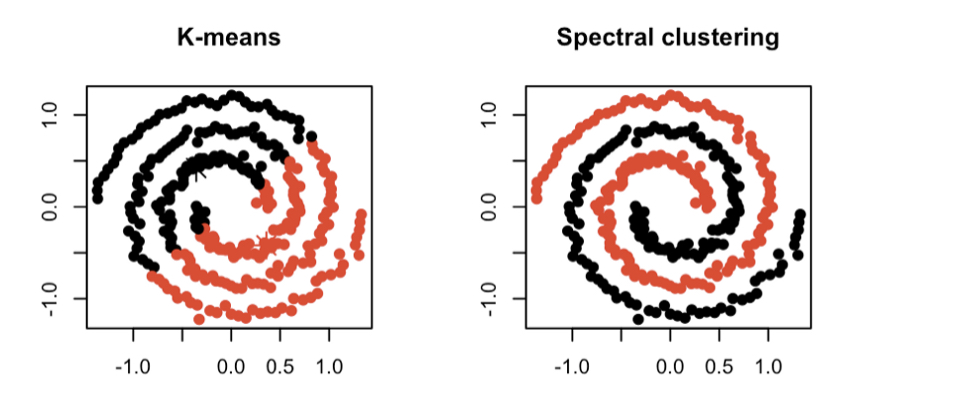

In [345]:
Image("spectral_clustering.png")

source: https://towardsdatascience.com/spectral-clustering-82d3cff3d3b7

- Kmeans clusters data points that physically close to each other, whether they belong to the same group or no
- Spectral clustering, in a way, fix the issue with Kmeans when data set is more complex. Data points in spectral clustering are grouped together when they are connected (data points from different clusters are not connected at all)

The high level implementation of spectral clustering follows:
1. **compute similiarty graph**; whether it is KNN, fully connected or ε-neighborhood graph, we are trying to create a connection between all the points. 
2. **convert the data to low-dimensional space**; sometime the data points to be far from each other (coule be farther way than a data point in a different cluster), but that does not mean they are not connect. So the objective is to cluster everything that is close to each other when data set is converted into a low-dimension space.
3. **create the cluster**; using the second eigenvalue to assign values (2nd vector indicates how closely connected the data are in a graph)

In [346]:
cluster = SpectralClustering(n_clusters = 2, affinity='nearest_neighbors')

In [347]:
labels = cluster.fit_predict(X)

/Users/summerzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


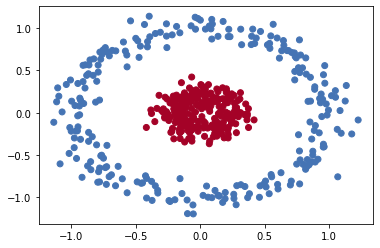

In [348]:
colors=np.array(['#4574B4','#A40227'])
plt.scatter(X[:,0], X[:,1], c=colors[labels])
plt.show()

## 4.  kmeans accuracy

Since kmeans is a clustering methods, not classification, we do not have the group truth. In other words, we do not know the actual Y and thus cannot calculate the real accuracy score. 

The way to come around it is that we can find the mode of each clustering and use the mode as our predicted Y.  

In [454]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from statistics import mode

In [455]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [456]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [457]:
centroids, labels = kmeans(X, K=2, centroids='kmeans++', tolerance=0.01)

In [458]:
acc, pred, matrix = likely_confusion_matrix(y, labels)

In [475]:
matrix

(       False  True
 False    175    37
 True      13   344,
 0.9121265377855887)

In [460]:
acc

0.9121265377855887

- we can see from the likely_confusion_matrix output that the accuracy is about 0.9. However, this is more or less cheating because we just randomly assumed which ever is the most in the cluster is 1. Again, kmeans is a clustering methods which has an objective to cluster datapoints together based on their distances. It is not a classification question, hence, there is no actual y in this case.

## 5. Kmeans Application

In [461]:
from PIL import Image

### grayed image

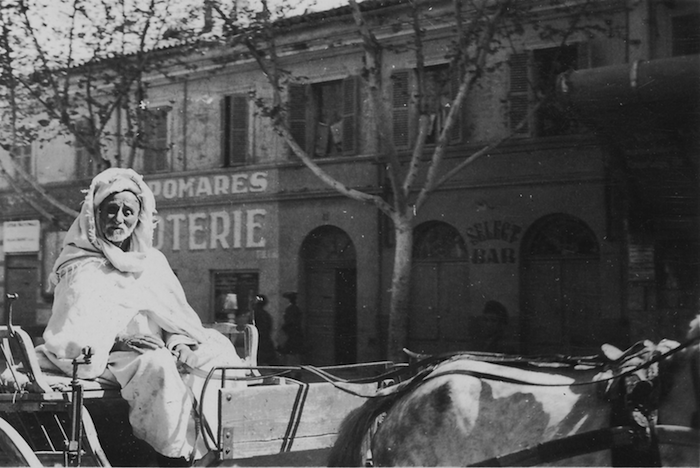

In [463]:
img = Image.open('../kmeans-summerzhang423/kmeans/north-africa-1940s-grey.png')
h = img.height
w = img.width
X_grayscale = np.array(img).flatten().astype(float).reshape(-1, 1)
img

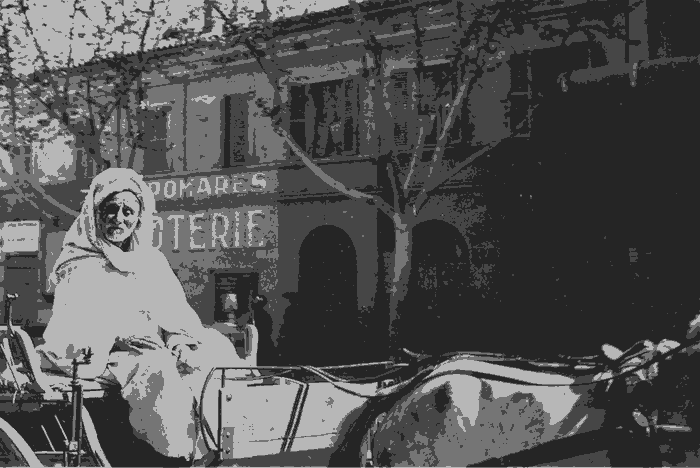

In [464]:
k=4
centroids, labels = kmeans(X_grayscale, K=k, centroids='kmeans++', tolerance=.01)
centroids = centroids.astype(np.uint8)
X_grayscale = centroids[labels] # reassign all points

img_pred = Image.fromarray(X_grayscale.reshape(h,w), 'L')
img_pred

### color image

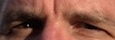

In [465]:
img = Image.open('../kmeans-summerzhang423/kmeans/eyes.png')
h = img.height
w = img.width
X_reshaped = np.array(img_parrt).flatten().astype(float).reshape(-1,1,3)
img_parrt

In [466]:
k=32
centroids, labels = kmeans(X_reshaped, K=k, centroids='kmeans++', tolerance=.01)
centroids = centroids.astype(np.uint8)
X_reshaped = centroids[labels] # reassign all points

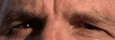

In [470]:
img_pred = Image.fromarray(X_reshaped.reshape(h,w,3))
img_pred

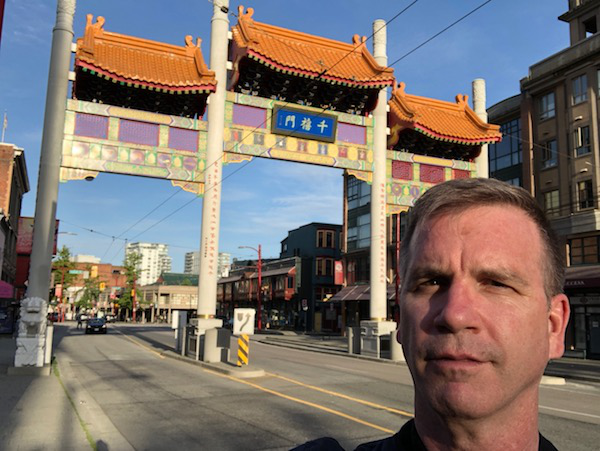

In [473]:
img_1 = Image.open('../kmeans-summerzhang423/kmeans/parrt-vancouver.jpg')
h = img.height
w = img.width
X_1_reshape = np.array(img_1).flatten().astype(float).reshape(-1,1,3)
img_1

In [474]:
k=32
centroids, labels = kmeans(X_1_reshape, K=k, centroids='kmeans++', tolerance=.01)
centroids = centroids.astype(np.uint8)
X_1_reshape = centroids[labels] # reassign all points

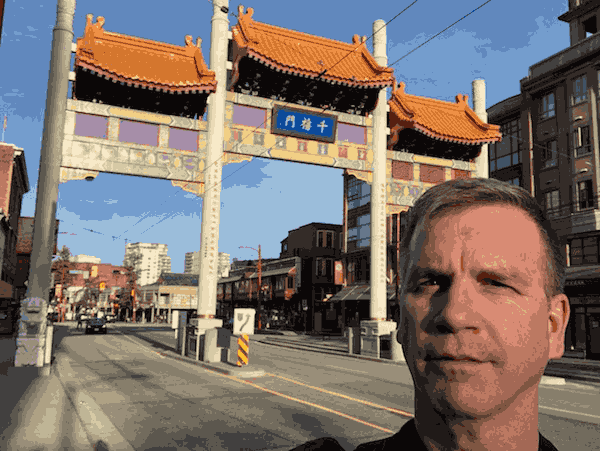

In [479]:
img_pred = Image.fromarray(X_1_reshape.reshape(h,w,3))
img_pred


# 6.  Conclusion

In summary, we have looked at the definition of what kmeans does, how the algorithm is implemented. We then looked at the visual representation on how Kmeans is applied for 1D, 2D or multiple-Dimension datasets. During the process we noticed:

    - the initial k centroid heavily impact the final result
    - data complexity also influence the kmeans performance

In order to overcome these obsticles, we have done the following two methods:

    - we implemented a new method to select initializer k, which is known as kmeans++.
    - we tried to used spectral clustering method to completely overcome data complexity
    
Lastly, we applied kmeans methods to one of the real-world applications - image compression. We tried both on greyed picture and colored pictures. We noticed that the more clusters we have, the longer it takes the algorithm to run, which indicates that kmeans could be very expensive to run on a scale.  